<a href="https://colab.research.google.com/github/rishichhabra29/DL_Assignments/blob/main/Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from tensorflow.keras.datasets import mnist
import numpy as np
import pandas as pd

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train_flat = x_train.reshape(x_train.shape[0], -1)
x_test_flat = x_test.reshape(x_test.shape[0], -1)

x_train_df = pd.DataFrame(x_train_flat)
y_train_df = pd.DataFrame(y_train, columns=["label"])

x_test_df = pd.DataFrame(x_test_flat)
y_test_df = pd.DataFrame(y_test, columns=["label"])

train_df = pd.concat([x_train_df, y_train_df], axis=1)
test_df = pd.concat([x_test_df, y_test_df], axis=1)


full_df = pd.concat([train_df, test_df], ignore_index=True)

full_df_array = full_df.values



In [ ]:
np.random.shuffle(full_df_array)
split_ratio = 0.7
split_index = int(len(full_df_array) * split_ratio)

val_split_ratio = 0.8
val_split_index = int(val_split_ratio * split_index)

train_split = full_df_array[:val_split_index]
val_split = full_df_array[val_split_index:split_index]
test_split = full_df_array[split_index:]

train_df = pd.DataFrame(train_split, columns=full_df.columns)
val_df = pd.DataFrame(val_split, columns=full_df.columns)
test_df = pd.DataFrame(test_split, columns=full_df.columns)

X_train = train_df.drop('label', axis=1).values / 255.0
y_train = train_df['label'].values
X_val = val_df.drop('label', axis=1).values / 255.0
y_val = val_df['label'].values
X_test = test_df.drop('label', axis=1).values / 255.0
y_test = test_df['label'].values

num_classes = 10
y_train_encoded = np.zeros((len(y_train), num_classes))
y_train_encoded[np.arange(len(y_train)), y_train] = 1

y_val_encoded = np.zeros((len(y_val), num_classes))
y_val_encoded[np.arange(len(y_val)), y_val] = 1

y_test_encoded = np.zeros((len(y_test), num_classes))
y_test_encoded[np.arange(len(y_test)), y_test] = 1

epochs = 25
batch_size = 24
input_size = X_train.shape[1]
hidden_size_1 = 512
hidden_size_2 = 128
output_size = 10
activation_function = 'relu'
initialization = "he"
dropout_rate = 0.5
learning_rate = 0.1
momentum = 0.9
reg_lambda = 0.01
eps = 1e-6
alpha = 0.9
dropout = False
batch_norm = False
sgd_with_momentum = False
cosine_annealing = False
patience = 5

In [ ]:
class FullyConnectedNeuralNetwork:
    def __init__(self, X, input_size, hidden_size_1, hidden_size_2, output_size, dropout_rate, learning_rate, momentum, reg_lambda, eps, alpha,
                 dropout, batch_norm, sgd_with_momentum, cosine_annealing, activation='sigmoid', initialization="he"):
        self.set_activation(activation)
        if initialization == "he":
          self.w1 = np.random.randn(input_size, hidden_size_1)*np.sqrt(2/input_size)
          self.w2 = np.random.randn(hidden_size_1, hidden_size_2)*np.sqrt(2/hidden_size_1)
          self.w3 = np.random.randn(hidden_size_2, output_size)*np.sqrt(2/hidden_size_2)
          self.b1 = np.ones((1, hidden_size_1))
          self.b2 = np.ones((1, hidden_size_2))
          self.b3 = np.ones((1, output_size))
        elif initialization == "Xavier":
          self.w1 = np.random.randn(input_size, hidden_size_1)*np.sqrt(1/input_size)
          self.w2 = np.random.randn(hidden_size_1, hidden_size_2)*np.sqrt(1/hidden_size_1)
          self.w3 = np.random.randn(hidden_size_2, output_size)*np.sqrt(1/hidden_size_2)
          self.b1 = np.ones((1, hidden_size_1))
          self.b2 = np.ones((1, hidden_size_2))
          self.b3 = np.ones((1, output_size))
        else:
          self.unsupervised_pretraining(X, input_size, hidden_size_1, hidden_size_2, output_size)




        self.dropout_rate = dropout_rate
        self.reg_lambda = reg_lambda
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.eps = eps
        self.alpha = alpha
        self.dropout = dropout
        self.batch_norm = batch_norm
        self.sgd_with_momentum = sgd_with_momentum
        self.cosine_annealing = cosine_annealing

        self.gamma_1 = np.random.randn(1, hidden_size_1)
        self.beta_1 = np.random.randn(1, hidden_size_1)
        self.gamma_2 = np.random.randn(1, hidden_size_2)
        self.beta_2 = np.random.randn(1, hidden_size_2)

        # Running statistics for batch normalization
        self.running_mean_1 = np.zeros((1, hidden_size_1))
        self.running_var_1 = np.ones((1, hidden_size_1))
        self.running_mean_2 = np.zeros((1, hidden_size_2))
        self.running_var_2 = np.ones((1, hidden_size_2))

    def unsupervised_pretraining(self, X, input_size, hidden_size_1, hidden_size_2, output_size):
        self.reg_lambda = 0.01
        self.w1,self.b1 = self.pretraining(X, input_size, hidden_size_1)
        self.h1 = self.activation(np.dot(X, self.w1) + self.b1)

        self.w2,self.b2 = self.pretraining(self.h1, hidden_size_1, hidden_size_2)
        self.h2 = self.activation(np.dot(self.h1, self.w2) + self.b2)

        self.w3,self.b3 = np.random.randn(hidden_size_2, output_size), np.ones((1, output_size))


    def pretraining(self, X, input_size, hidden_size):
        n_samples = X.shape[0]
        w1, w2 = np.random.randn(input_size, hidden_size), np.random.randn(hidden_size, input_size)
        b1, b2 = np.ones((1, hidden_size)), np.ones((1, input_size))
        for epoch in range(3):
          a1 = np.dot(X, w1) + b1
          h1 = self.activation(a1)
          output = np.dot(h1, w2) + b2

          learning_rate = 0.01
          delta = -(X - output)

          w2 -= learning_rate * (np.dot(h1.T, delta) /n_samples)
          b2 -= learning_rate * (np.mean(delta, axis=0, keepdims=True)/n_samples)
          w1 -= learning_rate * (np.dot(X.T, np.dot(delta, w2.T) * self.activation_derivative(h1))/n_samples)
          b1 -= learning_rate * (np.mean(np.dot(delta, w2.T) * self.activation_derivative(h1), axis=0, keepdims=True)/n_samples)

        return w1, b1

    def set_activation(self, activation):
        activations = {
            'sigmoid': (self.sigmoid, self.sigmoid_derivative),
            'relu': (self.relu, self.relu_derivative),
            'tanh': (self.tanh, self.tanh_derivative),
            'leaky_relu': (self.leaky_relu, self.leaky_relu_derivative),
            'elu': (self.elu, self.elu_derivative),
            'selu': (self.selu, self.selu_derivative)
        }
        if activation in activations:
            self.activation, self.activation_derivative = activations[activation]
        else:
            raise ValueError(f"Invalid activation function '{activation}'. Choose from {list(activations.keys())}.")

    def set_training_mode(self, mode):
        """Switch between training and testing modes."""
        self.training = mode

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def relu(self, x):
        return np.maximum(0, x)

    def tanh(self, x):
        return np.tanh(x)

    def leaky_relu(self, x, alpha=0.01):
        return np.maximum(alpha * x, x)

    def elu(self, x, alpha=1.0):
        return np.where(x > 0, x, alpha * (np.exp(x) - 1))

    def selu(self, x):
        alpha = 1.67326324235437728481704299167
        scale = 1.05070098735548049341933498529
        return scale * np.where(x > 0, x, alpha * (np.exp(x) - 1))

    def sigmoid_derivative(self, f_x):
        return f_x * (1 - f_x)

    def tanh_derivative(self, f_x):
        return 1 - f_x**2

    def elu_derivative(self, f_x, alpha=1.0):
        return np.where(f_x > 0, 1, f_x + alpha)

    def selu_derivative(self, f_x):
        alpha = 1.67326324235437728481704299167
        scale = 1.05070098735548049341933498529
        return np.where(f_x > 0, scale, (f_x + scale * alpha))

    def relu_derivative(self, f_x):
        return np.where(f_x > 0, 1, 0)

    def leaky_relu_derivative(self, f_x, alpha=0.01):
        return np.where(f_x > 0, 1, alpha)


    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    def annealing(self, epoch):
        lr = self.learning_rate * 0.5 * (1 + np.cos(np.pi * epoch / 25))
        return lr


    def apply_dropout(self, layer_output, layer_name):
        if self.training:
            dropout_mask = (np.random.rand(*layer_output.shape) > self.dropout_rate).astype(np.float32)
            setattr(self, f"{layer_name}_mask", dropout_mask)  # Dynamically create mask attribute
            return layer_output * dropout_mask  # Apply the mask
        else:
            return layer_output * (1 - self.dropout_rate)

    def forward(self, X):

        self.a1 = np.dot(X, self.w1) + self.b1
        self.h1 = self.activation(self.a1)

        if self.batch_norm == True:
          if self.training:
            self.a1_mean = np.mean(self.a1, axis=0, keepdims=True)
            self.a1_var = np.var(self.a1, axis=0, keepdims=True)
            self.running_mean_1 = self.alpha * self.running_mean_1 + (1 - self.alpha) * self.a1_mean
            self.running_var_1 = self.alpha * self.running_var_1 + (1 - self.alpha) * self.a1_var
          else:
            self.a1_mean = self.running_mean_1
            self.a1_var = self.running_var_1

          self.a1_std = np.sqrt(self.a1_var + self.eps)
          self.a1_st_form = (self.a1 - self.a1_mean) / self.a1_std
          self.a1_norm = self.gamma_1 * self.a1_st_form + self.beta_1
          #overwrite h1 in batch_norm
          self.h1 = self.activation(self.a1_norm)

        if self.dropout == True:
          self.h1 = self.apply_dropout(self.h1, "layer1")

        self.a2 = np.dot(self.h1, self.w2) + self.b2
        self.h2 = self.activation(self.a2)

        if self.batch_norm == True:
          if self.training:
            self.a2_mean = np.mean(self.a2, axis=0, keepdims=True)
            self.a2_var = np.var(self.a2, axis=0, keepdims=True)
            self.running_mean_2 = self.alpha * self.running_mean_2 + (1 - self.alpha) * self.a2_mean
            self.running_var_2 = self.alpha * self.running_var_2 + (1 - self.alpha) * self.a2_var
          else:
            self.a2_mean = self.running_mean_2
            self.a2_var = self.running_var_2

          self.a2_std = np.sqrt(self.a2_var + self.eps)
          self.a2_st_form = (self.a2 - self.a2_mean) / self.a2_std
          self.a2_norm = self.gamma_2 * self.a2_st_form + self.beta_2
          self.h2 = self.activation(self.a2_norm)

        if self.dropout == True:
          self.h2 = self.apply_dropout(self.h2, "layer2")

        self.a3 = np.dot(self.h2, self.w3) + self.b3
        self.output = self.softmax(self.a3)
        return self.output

    def compute_loss(self, y_true, y_pred):
        n_samples = y_true.shape[0]
        epsilon = 1e-9
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        loss = -np.sum(y_true * np.log(y_pred)) / n_samples

        reg_loss = (self.reg_lambda / (2*n_samples)) * (np.sum(self.w1**2) + np.sum(self.w2**2) + np.sum(self.w3**2))
        return loss + reg_loss

    def backward(self, X, y, epoch):
        n_samples = X.shape[0]

        # Output layer
        output_delta =-(y - self.output)

        # Hidden layer 2
        hidden_error_2 = np.dot(output_delta, self.w3.T)
        hidden_delta_2 = hidden_error_2 * self.activation_derivative(self.h2)
        if self.dropout == True:
          hidden_delta_2 *= self.layer2_mask

        if self.batch_norm == True:
          d_gamma_2 = np.sum(hidden_delta_2 * self.a2_st_form, axis=0, keepdims=True)
          d_beta_2 = np.sum(hidden_delta_2, axis=0, keepdims=True)

          hidden_delta_2 = (hidden_delta_2 * self.gamma_2) * (
              (((n_samples-1)/(n_samples*self.a2_std)))-
              (((self.a2 - self.a2_mean) * (self.a2 - self.a2_mean)) /
              (n_samples * self.a2_std**3))
          )

        # Hidden layer 1
        hidden_error_1 = np.dot(hidden_delta_2, self.w2.T)
        hidden_delta_1 = hidden_error_1 * self.activation_derivative(self.h1)
        if self.dropout == True:
          hidden_delta_1 *= self.layer1_mask

        if self.batch_norm == True:
          d_gamma_1 = np.sum(hidden_delta_1 * self.a1_st_form, axis=0, keepdims=True)
          d_beta_1 = np.sum(hidden_delta_1, axis=0, keepdims=True)

          hidden_delta_1 = (hidden_delta_1 * self.gamma_1) * (
              (((n_samples-1)/(n_samples*self.a1_std))) -
              (((self.a1 - self.a1_mean) * (self.a1 - self.a1_mean)) /
              (n_samples * self.a1_std**3))
          )

        if self.cosine_annealing == True:
          self.learning_rate = self.annealing(epoch)

        dw3 = self.learning_rate * ((np.dot(self.h2.T, output_delta) + self.reg_lambda * self.w3)/n_samples)
        db3 = self.learning_rate * (np.mean(output_delta, axis=0, keepdims=True)/n_samples)
        dw2 = self.learning_rate * ((np.dot(self.h1.T, hidden_delta_2) + self.reg_lambda * self.w2)/n_samples)
        db2 = self.learning_rate * (np.mean(hidden_delta_2, axis=0, keepdims=True)/n_samples)
        dw1 = self.learning_rate * ((np.dot(X.T, hidden_delta_1) + self.reg_lambda * self.w1)/n_samples)
        db1 = self.learning_rate * (np.mean(hidden_delta_1, axis=0, keepdims=True)/n_samples)

        if self.batch_norm == True:
          self.gamma_2 -= self.learning_rate * d_gamma_2/n_samples
          self.beta_2 -= self.learning_rate * d_beta_2/n_samples
          self.gamma_1 -= self.learning_rate * d_gamma_1/n_samples
          self.beta_1 -= self.learning_rate * d_beta_1/n_samples

        if self.sgd_with_momentum == True:

          dw3 = self.momentum * dw3 + dw3
          db3 = self.momentum * db3 + db3
          dw2 = self.momentum * dw2 + dw2
          db2 = self.momentum * db2 + db2
          dw1 = self.momentum * dw1 + dw1
          db1 = self.momentum * db2 + db1

        self.w3 -= dw3
        self.b3 -= db3
        self.w2 -= dw2
        self.b2 -= db2
        self.w1 -= dw1
        self.b1 -= db1

    def backward_with_nag(self, X, y):
      n_samples = X.shape[0]

      # Nesterov lookahead for weights
      w1_lookahead = self.w1 - self.momentum * self.v_w1
      w2_lookahead = self.w2 - self.momentum * self.v_w2
      w3_lookahead = self.w3 - self.momentum * self.v_w3

      # Compute output layer delta
      output_delta = -(y - self.output)

      # Hidden layer 2
      hidden_error_1 = np.dot(output_delta, w3_lookahead.T)
      hidden_delta_1 = hidden_error_1 * self.activation_derivative(self.h2)

      # Hidden layer 1
      hidden_error_2 = np.dot(hidden_delta_1, w2_lookahead.T)
      hidden_delta_2 = hidden_error_2 * self.activation_derivative(self.h1)

      # Update velocity and weights
      self.v_w3 = self.momentum * self.v_w3 + self.learning_rate * np.dot(self.h2.T, output_delta) / n_samples
      self.v_b3 = self.momentum * self.v_b3 + self.learning_rate * np.mean(output_delta, axis=0, keepdims=True)

      self.v_w2 = self.momentum * self.v_w2 + self.learning_rate * np.dot(self.h1.T, hidden_delta_1) / n_samples
      self.v_b2 = self.momentum * self.v_b2 + self.learning_rate * np.mean(hidden_delta_1, axis=0, keepdims=True)

      self.v_w1 = self.momentum * self.v_w1 + self.learning_rate * np.dot(X.T, hidden_delta_2) / n_samples
      self.v_b1 = self.momentum * self.v_b1 + self.learning_rate * np.mean(hidden_delta_2, axis=0, keepdims=True)

      # Apply updates
      self.w3 -= self.v_w3
      self.b3 -= self.v_b3

      self.w2 -= self.v_w2
      self.b2 -= self.v_b2

      self.w1 -= self.v_w1
      self.b1 -= self.v_b1

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay

def train_model_with_early_stopping(nn, X_train, y_train, X_val, y_val, X_test, y_test, batch_size, epochs, patience):

    train_losses, val_losses, test_losses, train_accuracies, val_accuracies, test_accuracies = [], [], [], [], [], []
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        epoch_loss = 0.0
        num_batches = int(np.floor(len(X_train) / batch_size))

        for i in range(num_batches):
            X_batch = X_train[i * batch_size:(i + 1) * batch_size]
            y_batch = y_train[i * batch_size:(i + 1) * batch_size]

            nn.set_training_mode(True)
            nn.forward(X_batch)
            # epoch_loss += nn.compute_loss(y_batch, nn.output)
            nn.backward(X_batch, y_batch, epoch)

        # Calculate training accuracy
        nn.set_training_mode(False)
        nn.forward(X_train)
        epoch_loss = nn.compute_loss(y_train, nn.output)
        y_pred_train = np.argmax(nn.output, axis=1)
        y_true_train = np.argmax(y_train, axis=1)
        train_accuracy = accuracy_score(y_true_train, y_pred_train)

        # Validation loss and accuracy
        nn.forward(X_val)
        val_loss = nn.compute_loss(y_val, nn.output)
        y_pred_val = np.argmax(nn.output, axis=1)
        y_true_val = np.argmax(y_val, axis=1)
        val_accuracy = accuracy_score(y_true_val, y_pred_val)

        # testing loss and accuracy
        nn.forward(X_test)
        test_loss = nn.compute_loss(y_test, nn.output)
        y_pred_test = np.argmax(nn.output, axis=1)
        y_true_test = np.argmax(y_test, axis=1)
        test_accuracy = accuracy_score(y_true_test, y_pred_test)

        # Store metrics
        train_losses.append(epoch_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

        print(
            f"Epoch {epoch + 1}/{epochs}: "
            f"Train Loss = {epoch_loss:.4f}, Train Accuracy = {train_accuracy:.4f}, "
            f"Val Loss = {val_loss:.4f}, Val Accuracy = {val_accuracy:.4f}"
        )

        # Early stopping logic
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch + 1}")
                break

    return train_losses, val_losses, test_losses, train_accuracies, val_accuracies, test_accuracies

def plot_metrics_with_validation(train_losses, val_losses, test_losses, train_accuracies, val_accuracies, test_accuracies):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss', color='red')
    plt.plot(epochs, val_losses, label='Val Loss', color='orange')
    plt.plot(epochs, test_losses, label='Test Loss', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss per Epoch')
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy', color='blue')
    plt.plot(epochs, val_accuracies, label='Val Accuracy', color='green')
    plt.plot(epochs, test_accuracies, label='Test Accuracy', color='purple')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy per Epoch')
    plt.legend()

    plt.show()

# Confusion matrix
def plot_confusion_matrix(nn, X, y_true):
    nn.forward(X)
    y_pred = np.argmax(nn.output, axis=1)
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='viridis')
    plt.title("Confusion Matrix")
    plt.show()


nn = FullyConnectedNeuralNetwork(X_train, input_size, hidden_size_1, hidden_size_2, output_size, dropout_rate, learning_rate, momentum, reg_lambda, eps, alpha,
                                 dropout, batch_norm, sgd_with_momentum, cosine_annealing,  activation_function, initialization)


In [ ]:
# Train the model
train_losses, val_losses, test_losses, train_accuracies, val_accuracies, test_accuracies  = train_model_with_early_stopping(nn, X_train, y_train_encoded, X_val, y_val_encoded, X_test, y_test_encoded,
                                                                                                                            batch_size, epochs, patience)


Epoch 1/25: Train Loss = 0.1754, Train Accuracy = 0.9463, Val Loss = 0.1878, Val Accuracy = 0.9422
Epoch 2/25: Train Loss = 0.1096, Train Accuracy = 0.9671, Val Loss = 0.1362, Val Accuracy = 0.9588
Epoch 3/25: Train Loss = 0.0812, Train Accuracy = 0.9760, Val Loss = 0.1189, Val Accuracy = 0.9630
Epoch 4/25: Train Loss = 0.0660, Train Accuracy = 0.9801, Val Loss = 0.1125, Val Accuracy = 0.9656
Epoch 5/25: Train Loss = 0.0521, Train Accuracy = 0.9841, Val Loss = 0.1071, Val Accuracy = 0.9670
Epoch 6/25: Train Loss = 0.0437, Train Accuracy = 0.9870, Val Loss = 0.1048, Val Accuracy = 0.9681
Epoch 7/25: Train Loss = 0.0384, Train Accuracy = 0.9882, Val Loss = 0.1052, Val Accuracy = 0.9691
Epoch 8/25: Train Loss = 0.0325, Train Accuracy = 0.9901, Val Loss = 0.1010, Val Accuracy = 0.9701
Epoch 9/25: Train Loss = 0.0306, Train Accuracy = 0.9910, Val Loss = 0.1026, Val Accuracy = 0.9708
Epoch 10/25: Train Loss = 0.0270, Train Accuracy = 0.9922, Val Loss = 0.0999, Val Accuracy = 0.9714
Epoch 11/

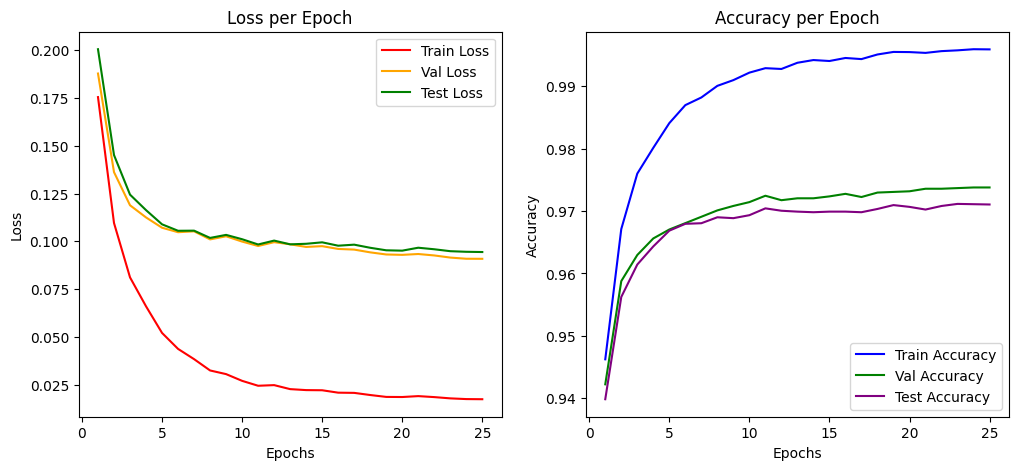

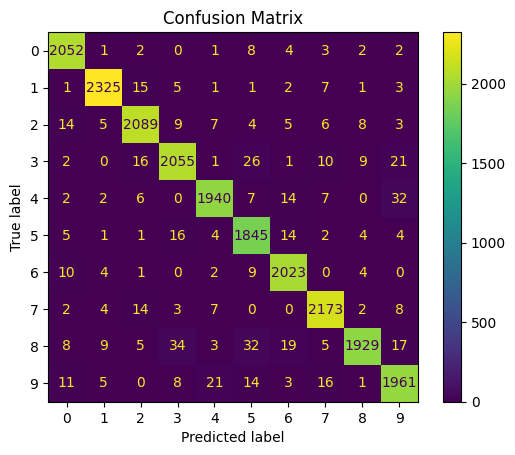

In [ ]:
# Plot metrics
plot_metrics_with_validation(train_losses, val_losses, test_losses, train_accuracies, val_accuracies, test_accuracies)

# Generate confusion matrix
plot_confusion_matrix(nn, X_test, y_test)